# Import Modules

In [72]:
import numpy as np
import matplotlib.pyplot as plt

import time
import datetime
from time import sleep

import pvaccess as pva

## Scott Helper Fuctions

#### Timer decorator
Code copied directly from https://dev.to/kcdchennai/python-decorator-to-measure-execution-time-54hk

In [73]:
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        #print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        print(f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

### caget and pvget
When you need to quickly check a process variable... and all you have is pvapy

In [74]:
def caget(channel_name):
    """ Channel Access get """
    return pva.Channel(channel_name, pva.CA).get().getPyObject()

def pvget(channel_name):
    """ PVAccess get """
    return pva.Channel(channel_name, pva.PVA).get().getPyObject()

In [75]:
caget("PULSEGEN:info")

'DOLPHINDAQ,TeensyPulse,00,20240807'

In [76]:
pvget("ELECTRON-DAQ:info")

'Diode Teensy-Serial PVA Server, 20240724'

## EPICS Functions

## System Configuration

### Basic settings like repetition rate

In [158]:
proton_dt = pva.Channel("PROTON:dt:set", pva.CA)
electron_dt = pva.Channel("ELECTRON:dt:set", pva.CA)
laser_dt = pva.Channel("LASER:powers:dt:set", pva.CA)
pulse_rep = pva.Channel("PULSEGEN:reprate:set", pva.CA)

proton_dt.put(5.0e-6) # seconds
electron_dt.put(5.0e-6) # seconds
laser_dt.put(5) # microseconds
pulse_rep.put(50) # Hz

#### PVAccess and Channel Access Variables

In [80]:
powers_set_CA= pva.Channel("LASER:powers:set", pva.CA)
powers_RBV_CA = pva.Channel("LASER:powers", pva.CA) # readback value
powers_RBV_PROC_CA = pva.Channel("LASER:powers.PROC", pva.CA) # force readback value record to process
etrace_PVA = pva.Channel("ELECTRON-DAQ:trace", pva.PVA)
ptrace_PVA = pva.Channel("PROTON-DAQ:trace", pva.PVA)
etrig_CA = pva.Channel("ELECTRON:trigger:count", pva.CA)
etrig_PROC_CA = pva.Channel("ELECTRON:trigger:count.PROC", pva.CA)

In [161]:
def synchronous_goto_setpoint(setpoint, setter_CA, getter_CA, getter_PROC_CA, sleep_secs=0.01):
    """ Set channel and then block until the readback channel's value (scalar array) exactly matches the setpoint value (scalar array) """
    assert(isinstance(setpoint, np.ndarray))
    assert(isinstance(setter_CA, pva.pvaccess.Channel))
    assert(isinstance(getter_CA, pva.pvaccess.Channel))
    assert(isinstance(getter_PROC_CA, pva.pvaccess.Channel))
    assert(getter_PROC_CA.getName().endswith(".PROC"))
           
    setter_CA.putScalarArray(list(setpoint))
    while not np.array_equal(setter_CA.get().getScalarArray(), getter_CA.get().getScalarArray()): # compare our setpoint with our RBV
        getter_PROC_CA.put(1) # force immediate processing of the readback value record
        sleep(sleep_secs) # delay a moment before requesting another check
        
def get_synchronous_trigger_count(trig_CA, trig_PROC_CA):
    """Get the current trigger count from a device, forcing completed processing of the request before retrieval of the value"""    
    trig_PROC_CA.put(1) # force processing
    while trig_PROC_CA.get().get()['value'] == '\x01':  # ensure value is done being processed
        sleep(0.001)
    return np.int64(trig_CA.get().get()['value']) # get the most up-to-date trigger count
    
    
def await_synchronous_data(data_PVA, minimum_uniqueId):
    """Await a new set of data with uniqueId greater than the specified uniqueId"""    
    while True:
        pvobj = data_PVA.get('field(uniqueId)')
        uniqueId = pvobj["uniqueId"]
        # print(uniqueId) # DEBUG
        if uniqueId > minimum_uniqueId:
            break
        sleep(0.005)
        
@timeit
def realpulse(pulse, powers_set_CA=powers_set_CA, powers_RBV_CA=powers_RBV_CA, 
                powers_RBV_PROC_CA=powers_RBV_PROC_CA, etrace_PVA=etrace_PVA, 
                ptrace_PVA=ptrace_PVA, trig_CA=etrig_CA, trig_PROC_CA=etrig_PROC_CA):
    """ Real laser pulse and its response
    Inputs:
        pulse   1D NumPy Double array of 100 points - the desired pulse, from 0 to 255
        powers_set_CA   Channel object referring to 'LASER:powers:set' (Channel Access)
        powers_RBV_CA   Channel object referring to 'LASER:powers' (Channel Access)
        powers_RBV_PROC_CA Channel object referring to 'LASER:powers.PROC' (Channel Access - allows us to initiate PV processing)
        etrace_PVA     Channel object referring to 'ELECTRON-DAQ:trace' (PVAccess)
        ptrace_PVA     Channel object referring to 'ELECTRON-DAQ:trace' (PVAccess)
        trig_CA        Channel object referring to an official source of truth on the global trigger count (Channel Access)
        trig_PROC_CA     Channel object referring to the ".PROC" field of an official source of truth on the global trigger count (Channel Access)
    """

    # Data validity checks
    assert(isinstance(pulse, np.ndarray))
    assert(np.ndim(pulse) == 1)
    assert(len(pulse) == 100)
    assert(np.max(pulse) <= 255)
    assert(np.min(pulse) >= 0)
    if (np.count_nonzero(pulse - pulse.round() > 0)):
        raise Exception("Pulse array contains fractional values (should be only integers, from 0 to 255).")

    # Data type conversion to uint8
    pulse_uint8 = np.uint8(pulse)

    # Set the pulse values (blocking)
    synchronous_goto_setpoint(setpoint=pulse_uint8, setter_CA=powers_set_CA, getter_CA=powers_RBV_CA, getter_PROC_CA=powers_RBV_PROC_CA)
    minimum_shot_ID = get_synchronous_trigger_count(trig_CA, trig_PROC_CA)
    
    await_synchronous_data(etrace_PVA, minimum_shot_ID)
    await_synchronous_data(ptrace_PVA, minimum_shot_ID)

    electrons = etrace_PVA.get().get()['value'][0]['ushortValue']
    protons = ptrace_PVA.get().get()['value'][0]['ushortValue']
    
    return electrons, protons, pulse_uint8

In [145]:
def realpulse_OLD(pulse, powers_set_CA=powers_set_CA, powers_RBV_CA=powers_RBV_CA, 
                powers_RBV_PROC_CA=powers_RBV_PROC_CA, etrace_PVA=etrace_PVA, 
                ptrace_PVA=ptrace_PVA, extra_delay_secs=0):
    """ Real laser pulse and its response
    Inputs:
        pulse   1D NumPy Double array of 100 points - the desired pulse, from 0 to 255
        powers_set_CA   Channel object referring to 'LASER:powers:set' (Channel Access)
        powers_RBV_CA   Channel object referring to 'LASER:powers' (Channel Access)
        powers_RBV_PROC_CA Channel object referring to 'LASER:powers.PROC' (Channel Access - allows us to initiate PV processing)
        etrace_PVA     Channel object referring to 'ELECTRON-DAQ:trace' (PVAccess)
        ptrace_PVA     Channel object referring to 'ELECTRON-DAQ:trace' (PVAccess)
        """

    # Data validity checks
    assert(isinstance(pulse, np.ndarray))
    assert(np.ndim(pulse) == 1)
    assert(len(pulse) == 100)
    assert(np.max(pulse) <= 255)
    assert(np.min(pulse) >= 0)
    if (np.count_nonzero(pulse - pulse.round() > 0)):
        raise Exception("Pulse array contains fractional values (should be only integers, from 0 to 255).")

    # Data type conversion to uint8
    pulse_uint8 = np.uint8(pulse)

    # Set the pulse values (blocking)
    reach_setpoint(setpoint=pulse_uint8, setter_CA=powers_set_CA, getter_CA=powers_RBV_CA, getter_PROC_CA=powers_RBV_PROC_CA)

    if extra_delay_secs > 0:
        sleep(extra_delay_secs) # NTP jitter allowance / USB data pipeline buffer allowance / etc.
        
    now = datetime.datetime.now() # timestamp that must be surpassed in the data before continuing
    await_fresh_data(etrace_PVA, minimum_timestamp=now)
    await_fresh_data(ptrace_PVA, minimum_timestamp=now)

    electrons = etrace_PVA.get().get()['value'][0]['ushortValue']
    protons = ptrace_PVA.get().get()['value'][0]['ushortValue']
    
    return electrons, protons, pulse_uint8

def await_fresh_data(channel, minimum_timestamp=None):
    """Await a new set of data with timestamp after the current time (relies on precision clock synchronization)"""    
    if minimum_timestamp is None:
        minimum_timestamp = datetime.datetime.now() # timestamp that must be surpassed in the data before continuing

    while True:
        pvobj = channel.get('field(timeStamp)')
        pvtimestamp = datetime.datetime.fromtimestamp(pvobj["timeStamp"]["secondsPastEpoch"] + pvobj["timeStamp"]["nanoseconds"]*1e-9)
        # print(pvtimestamp) # DEBUG
        if pvtimestamp > minimum_timestamp:
            break
        sleep(0.005)

## Do some tests

In [133]:
ascending = np.uint8(np.linspace(0, 255, 100))
descending = np.uint8(np.linspace(255, 0, 100))
spiky = np.uint8(np.tile([0,255], 50))

In [136]:
def mymetric(myarray):
    return np.mean(np.diff(np.float64(myarray[5:-5])))

@timeit
def run_test():
    for i in range(10):
        for setpoint, label in zip([ascending, descending, spiky], ["ascending", "descending", "spiky"]):
            electrons, protons, pulse_uint8 = realpulse(setpoint);
            #print("\t\t\t\t\t\t{:>10}: {:06.2f}, {:06.2f}, {:06.2f}".format(label, mymetric(electrons), mymetric(protons), mymetric(pulse_uint8)))
    

In [159]:
run_test()

Function realpulse took 0.1352 seconds
Function realpulse took 0.0990 seconds
Function realpulse took 0.0974 seconds
Function realpulse took 0.0890 seconds
Function realpulse took 0.0819 seconds
Function realpulse took 0.0790 seconds
Function realpulse took 0.0993 seconds
Function realpulse took 0.0921 seconds
Function realpulse took 0.0720 seconds
Function realpulse took 0.0782 seconds
Function realpulse took 0.0869 seconds
Function realpulse took 0.1328 seconds
Function realpulse took 0.1366 seconds
Function realpulse took 0.0995 seconds
Function realpulse took 0.0989 seconds
Function realpulse took 0.0892 seconds
Function realpulse took 0.0761 seconds
Function realpulse took 0.0927 seconds
Function realpulse took 0.0841 seconds
Function realpulse took 0.0848 seconds
Function realpulse took 0.0787 seconds
Function realpulse took 0.1532 seconds
Function realpulse took 0.1084 seconds
Function realpulse took 0.0945 seconds
Function realpulse took 0.0848 seconds
Function realpulse took 0

In [92]:
# 3 seconds, 30 datapoints ===> Synchronous control loop at 10 Hz

### Non-timing tests

Function realpulse took 0.1134 seconds
Function realpulse took 0.0980 seconds


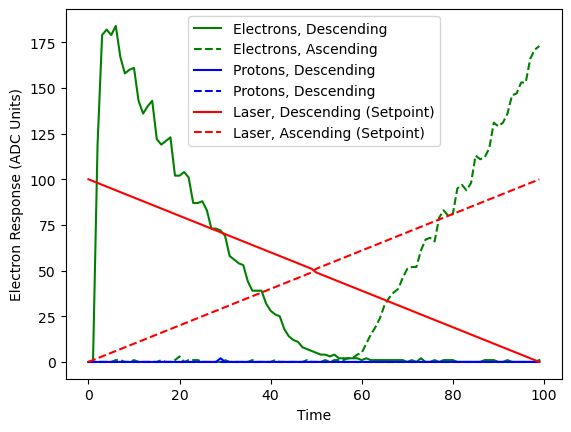

In [160]:
# test pulse 
pulse_descent = np.round(np.linspace(1, 0, 100)*100)
pulse_ascent = np.round(np.linspace(0, 1, 100)*100)
elecs1, prots1, pulse1 = realpulse(pulse_descent)
elecs2, prots2, pulse2 = realpulse(pulse_ascent)

plt.plot(elecs1, label="Electrons, Descending", c='g')
plt.plot(elecs2, '--', label="Electrons, Ascending", c='g')
plt.plot(prots1, label="Protons, Descending", c='b')
plt.plot(prots2, '--', label="Protons, Descending", c='b')
plt.plot(pulse1, label="Laser, Descending (Setpoint)", c='r')
plt.plot(pulse2, '--', label="Laser, Ascending (Setpoint)", c='r')
plt.ylabel("Electron Response (ADC Units)")
plt.xlabel("Time")
plt.legend()

Function realpulse took 0.0973 seconds
Function realpulse took 0.0737 seconds


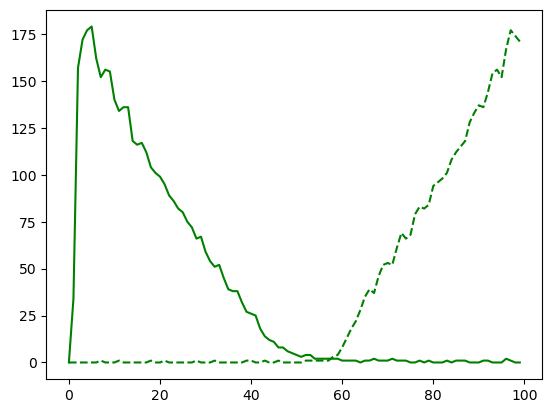

In [154]:
elecs1, prots1, pulse1 = realpulse(pulse_descent)
plt.plot(elecs1, label="Electrons, Descending", c='g')

elecs2, prots2, pulse2 = realpulse(pulse_ascent)
plt.plot(elecs2, '--', label="Electrons, Ascending", c='g')

array([ 0.,  1.,  1.,  2.,  2.,  3.,  3.,  4.,  4.,  5.,  5.,  6.,  6.,
        7.,  7.,  8.,  8.,  9.,  9., 10., 10., 11., 11., 12., 12., 13.,
       13., 14., 14., 15., 15., 16., 16., 17., 17., 18., 18., 19., 19.,
       20., 20., 21., 21., 22., 22., 23., 23., 24., 24., 25., 25., 26.,
       26., 27., 27., 28., 28., 29., 29., 30., 30., 31., 31., 32., 32.,
       33., 33., 34., 34., 35., 35., 36., 36., 37., 37., 38., 38., 39.,
       39., 40., 40., 41., 41., 42., 42., 43., 43., 44., 44., 45., 45.,
       46., 46., 47., 47., 48., 48., 49., 49., 50.])

In [115]:
for i in range(100):
    etrig_PROC_CA.put(1)
    while etrig_PROC_CA.get().get()['value'] == '\x01':
        sleep(0.001)
        print("Waiting...")
    trig_actual = np.int64(etrig_CA.get().get()['value'])

    while True:
        trig_data = etrace_PVA.get('field(uniqueId)').get()["uniqueId"]
        if trig_data > trig_actual:
            break
    print(trig_actual - trig_data)

Waiting...
-1
Waiting...
-1
Waiting...
Waiting...
-1
Waiting...
-1
Waiting...
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-2
-1
-1
Waiting...
Waiting...
Waiting...
Waiting...
-1
Waiting...
-2
Waiting...
-1
Waiting...
Waiting...
-1
Waiting...
Waiting...
-1
-1
Waiting...
Waiting...
-1
-1
Waiting...
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
Waiting...
Waiting...
-1
Waiting...
-1
Waiting...
Waiting...
-1
Waiting...
-1
Waiting...
-2
Waiting...
-2
Waiting...
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
Waiting...
Waiting...
Waiting...
-1
Waiting...
-1
Waiting...
-2
Waiting...
Waiting...
Waiting...
-1
Waiting...
-1
Waiting...
-1
Waiting...
Waiting...
Waiting...
-1
-1
Waiting...
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
Waiting...
Waiting...
Waiting...
-1
Waiting...
-2
Waiting...
-1
Waiting...
-1
Waiting...
-1
Waiting...
-1
Waiting...
-1
Waiting...
-1
Waiting...
Waiting...
-1
-1
Waiting...
-1
-1


1685326

In [111]:
etrig_PROC_CA.put(1) # force immediate processing of the readback value record

In [123]:
minimum_shot_ID = get_synchronous_trigger_count(etrig_CA, etrig_PROC_CA)
await_synchronous_data(etrace_PVA, minimum_shot_ID)
await_synchronous_data(ptrace_PVA, minimum_shot_ID)